# CycleGAN Homework: Van Gogh ↔ Photo Style Transfer (HW8)

Welcome to the 8th homework!

- Code cells that have `TODO` or `raise NotImplementedError` comments are left blank for you.
- Insert additional experiment cells whenever you need to debug, visualize, or keep notes.
- Keep this notebook clean and readable.

## Homework Baseline & Evaluation Criteria

**Baseline configuration**
- Dataset: `vangogh2photo` from the original CycleGAN release.
- Generators/ Discriminators
- Training
- Logging: save checkpoints in the training process.

**Evaluation criteria**
- `Pass / Baseline`: Model trains well, losses trend downward, and validation grids show recognizable Van Gogh ↔ photo translation.
- `Strong`: All baseline requirements + clear hyperparameter discussion, clean checkpoints, and at least one successful custom-image translation.
- `Excellent`: Includes ablations/experiments.



### Core Imports & Utilities



In [19]:
# Base imports and helpers (feel free to extend, but keep everything centralized here).
import os, sys, time, math, random, zipfile, urllib.request, shutil
from dataclasses import dataclass
from pathlib import Path

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms, datasets, utils as vutils
import torch.nn.init as init
from PIL import Image
from tqdm import tqdm
from torchvision.utils import save_image
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

def set_seed(seed: int = 2025):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(2025)


Device: cuda


## 1. Configuration

Define a `Config` dataclass (or a simple namespace) that stores paths, hyperparameters, and logging cadence. You are free to tweak values, but document any deviation from the baseline in your report.

**Checklist**
- [ ] Fill in every field (project name, directories, batch size, epochs, learning rate, lambda terms, sampling cadence).
- [ ] Create the necessary directories (`data`, `outputs/train`, `outputs/val`, `outputs/test`, `checkpoints`, etc.).
- [ ] Print `cfg` so that future cells can reference it and so graders can quickly see your settings.


In [20]:

from dataclasses import dataclass
@dataclass
class Config:
    project: str = "cyclegan_vangogh2photo_hw"
    data_root: str = "./data"
    dataset_name: str = "vangogh2photo"
    outputs: str = "./outputs"
    checkpoints: str = "./checkpoints"#data_root (資料集), outputs (輸出), checkpoints (模型儲存)
    img_size: int = 256
    batch_size: int = 2
    num_workers: int = 4
    epochs: int = 200
    lr: float = 2e-4
    beta1: float = 0.5
    beta2: float = 0.999
    decay_start_epoch = 100
    lambda_cyc: float = 10.0
    lambda_idt: float = 5.0
    sample_every: int = 10
    save_every_epochs: int = 50
    val_fixed_n: int = 4

cfg = Config()

Path(cfg.data_root).mkdir(parents=True, exist_ok=True)
Path(cfg.outputs).mkdir(parents=True, exist_ok=True)
Path(cfg.checkpoints).mkdir(parents=True, exist_ok=True)
Path(f"{cfg.outputs}/train").mkdir(parents=True, exist_ok=True)
Path(f"{cfg.outputs}/val").mkdir(parents=True, exist_ok=True)
Path(f"{cfg.outputs}/test").mkdir(parents=True, exist_ok=True)

cfg

Config(project='cyclegan_vangogh2photo_hw', data_root='./data', dataset_name='vangogh2photo', outputs='./outputs', checkpoints='./checkpoints', img_size=256, batch_size=2, num_workers=4, epochs=200, lr=0.0002, beta1=0.5, beta2=0.999, lambda_cyc=10.0, lambda_idt=5.0, sample_every=10, save_every_epochs=50, val_fixed_n=4)

## 2. Dataset Download (VanGogh ↔ Photo)

Download the official CycleGAN dataset, cache the zip, and extract it into `cfg.data_root`.


In [21]:
from pathlib import Path
import urllib.request
import zipfile

def download_and_extract_cyclegan_dataset(name: str, data_root: str):#存到data_root叫name
    data_root = Path(data_root)
    data_root.mkdir(parents=True, exist_ok=True)

    url = f"http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/{name}.zip"
    dest_zip = data_root / f"{name}.zip"#./data/vangogh2photo.zip
    target_dir = data_root / name#./data/vangogh2photo

    if target_dir.exists() and any(target_dir.iterdir()):
        print(f"[OK] Dataset already present at {target_dir}")
        return target_dir

    print(f"[DL] Downloading {url} -> {dest_zip}")
    try:
        urllib.request.urlretrieve(url, dest_zip)
    except Exception as e:
        print("[WARN] Primary URL failed:", e)
        raise

    print("[ZIP] Extracting...")
    with zipfile.ZipFile(dest_zip, 'r') as zf:
        zf.extractall(data_root)

    print("[CLEAN] Removing zip")
    dest_zip.unlink(missing_ok=True)

    return target_dir


data_dir = download_and_extract_cyclegan_dataset(cfg.dataset_name, cfg.data_root)
print("Data directory:", data_dir)
print("Subfolders:", list(Path(data_dir).iterdir()))

[OK] Dataset already present at data/vangogh2photo
Data directory: data/vangogh2photo
Subfolders: [PosixPath('data/vangogh2photo/testB'), PosixPath('data/vangogh2photo/trainB'), PosixPath('data/vangogh2photo/trainA'), PosixPath('data/vangogh2photo/testA')]


## 3. Datasets & Dataloaders

Create PyTorch datasets and dataloaders for each domain. Use  data augmentation (ex: horizontal flips, normalization to [-1, 1]) for training and deterministic transforms for validation/testing.

**Checklist**
- [ ] Build helper transforms for train/eval.
- [ ] Instantiate ImageFolder (or a custom dataset) for `trainA`, `trainB`, `testA`, and `testB`.
- [ ] Create dataloaders with the batch size and worker count from `cfg`.
- [ ] Cache a few fixed batches (`fixed_A`, `fixed_B`) for periodic sampling.
- [ ] Visualize at least one batch to ensure the transforms/normalization look correct.


Fixed batch A shape: torch.Size([2, 3, 256, 256])
Fixed batch B shape: torch.Size([2, 3, 256, 256])
Fixed batches for validation logging successfully grabbed and moved to device.


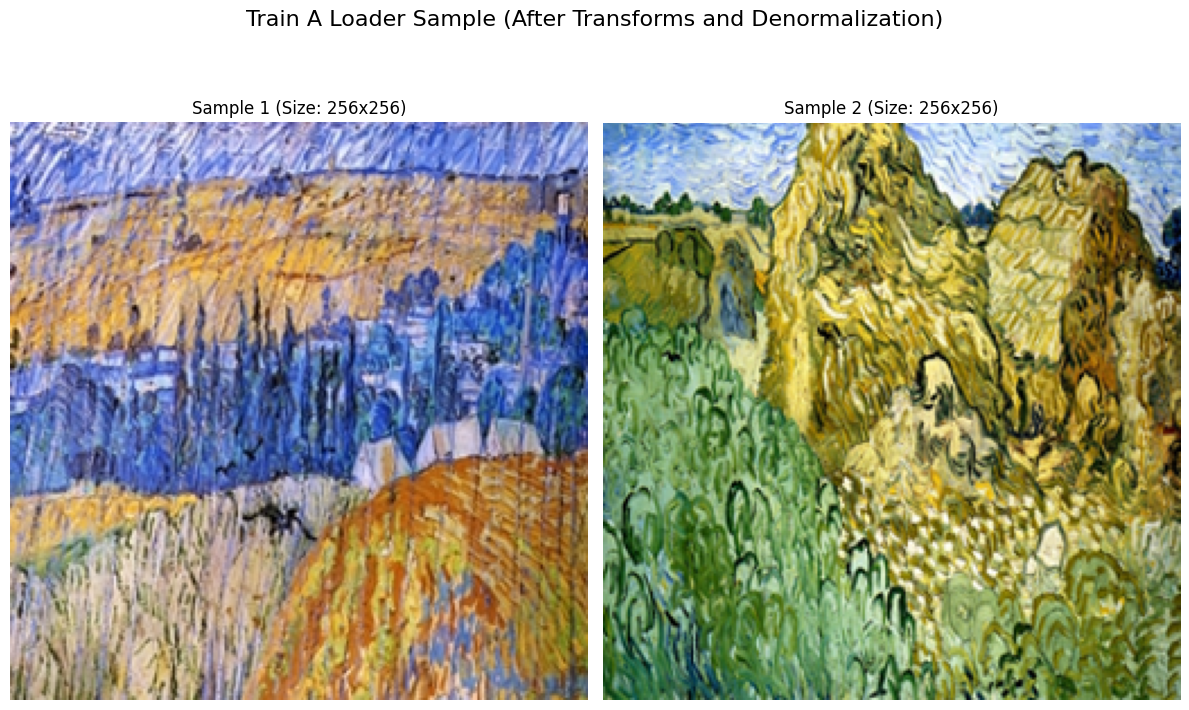

Transforms/Normalization check complete. Images should be colored and correctly cropped/sized.


In [22]:
def make_transforms(size: int):
    """Return the training transform pipeline (resize, flip, ToTensor, Normalize)."""
    return transforms.Compose([
        # 1. 調整大小: 將圖像的短邊縮放到 (size + 30) (e.g., 286)
        #    - 這樣隨機裁剪 (RandomCrop) 才有空間移動。
        transforms.Resize(int(size * 1.12), transforms.InterpolationMode.BICUBIC),

        # 2. 隨機裁剪: 裁剪回目標大小 (size x size)
        transforms.RandomCrop(size),

        # 3. 隨機翻轉: 隨機水平翻轉，增加資料多樣性。
        transforms.RandomHorizontalFlip(),

        # 4. 轉換為 Tensor
        transforms.ToTensor(),

        # 5. 標準化: 將像素值從 [0, 1] 映射到 [-1, 1]
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


def make_test_transforms(size: int):
    """Return the validation/test transform pipeline (resize, ToTensor, Normalize)."""
    return transforms.Compose([
        # 1. 調整大小: 將圖像的短邊縮放到 (size + 30) (e.g., 286)
        #    - 這樣隨機裁剪 (RandomCrop) 才有空間移動。
        transforms.Resize(int(size * 1.12), transforms.InterpolationMode.BICUBIC),


        transforms.RandomCrop(size),#裁剪回目標大小 (size x size)


        transforms.RandomHorizontalFlip(),# 隨機水平翻轉


        transforms.ToTensor(),#將像素值從 [0, 255] 轉換到 [0, 1]


        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])# 將像素值從 [0, 1] 映射到 [-1, 1]

trainA_path = Path(data_dir) / "trainA"
trainB_path = Path(data_dir) / "trainB"
testA_path  = Path(data_dir) / "testA"
testB_path  = Path(data_dir) / "testB"

# TODO: instantiate datasets (ImageFolder or a custom Dataset) for both domains
# Example:
# trainA = datasets.ImageFolder(root=str(trainA_path.parent), transform=make_transforms(cfg.img_size))
# trainA.samples = [(str(p), 0) for p in sorted(trainA_path.glob("*"))]
# trainB = ...
class reconstructdataset(Dataset):
    def __init__(self,root,transform=None):
      self.transform = transform
      self.image_paths = []
      for filename in os.listdir(root):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.image_paths.append(os.path.join(root, filename))

    def __len__(self):
      return len(self.image_paths)

    def __getitem__(self,idx):
      image_path = self.image_paths[idx]
      image = Image.open(image_path).convert("RGB")
      if self.transform:
            image = self.transform(image)

      # 返回圖像和一個虛擬標籤 (CycleGAN 是非監督學習)
      return image, 0


trainA = reconstructdataset(
    root=str(trainA_path),
    transform=make_transforms(cfg.img_size)
)
trainB = reconstructdataset(
    root=str(trainB_path),
    transform=make_transforms(cfg.img_size)
)

valA = reconstructdataset(
    root=str(testA_path),
    transform=make_test_transforms(cfg.img_size)
)

valB = reconstructdataset(
    root=str(testB_path),
    transform=make_test_transforms(cfg.img_size)
)

# TODO: wrap datasets in dataloaders
# trainA_loader = DataLoader(trainA, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers, drop_last=True)
# trainB_loader = ...
# valA_loader = ...
# valB_loader = ...
#DataLoader 接受一個 Dataset ，然後負責將單個樣本組合成批次（Batching）、打亂（Shuffling）、並使用多進程（num_workers）來加速載入
trainA_loader = DataLoader(
    trainA,
    batch_size=cfg.batch_size,
    shuffle=True,           # 訓練時需要打亂順序
    num_workers=cfg.num_workers,
    drop_last=True          # 確保批次大小一致，避免最後一個不完整的批次影響訓練
)
trainB_loader = DataLoader(
    trainB,
    batch_size=cfg.batch_size,
    shuffle=True,           # 訓練時需要打亂順序
    num_workers=cfg.num_workers,
    drop_last=True          # 確保批次大小一致，避免最後一個不完整的批次影響訓練
)
valA_loader = DataLoader(
    valA,
    batch_size=cfg.batch_size,
    shuffle=True,           # 訓練時需要打亂順序
    num_workers=cfg.num_workers,
    drop_last=True          # 確保批次大小一致，避免最後一個不完整的批次影響訓練
)
valB_loader = DataLoader(
    valB,
    batch_size=cfg.batch_size,
    shuffle=True,           # 訓練時需要打亂順序
    num_workers=cfg.num_workers,
    drop_last=True          # 確保批次大小一致，避免最後一個不完整的批次影響訓練
)
# TODO: grab fixed batches for visualization/logging
# fixed_A = next(iter(valA_loader))[0][:cfg.val_fixed_n].to(device)
# fixed_B = next(iter(valB_loader))[0][:cfg.val_fixed_n].to(device)
fixed_A = next(iter(valA_loader))[0][:cfg.val_fixed_n].to(device)

# 2. 緩存 B 域 (照片) 的固定批次
fixed_B = next(iter(valB_loader))[0][:cfg.val_fixed_n].to(device)

print(f"Fixed batch A shape: {fixed_A.shape}")
print(f"Fixed batch B shape: {fixed_B.shape}")
print("Fixed batches for validation logging successfully grabbed and moved to device.")


display_count = min(6, cfg.batch_size) # 顯示最多 6 張圖像

plt.figure(figsize=(12, 8))
plt.suptitle("Train A Loader Sample (After Transforms and Denormalization)", fontsize=16)

for i in range(display_count):
    plt.subplot(1, 2, i + 1)
    sample_A, _ = next(iter(trainA_loader))
    # 獲取單張圖像張量
    single_image_tensor = sample_A[i]

    # a) 逆標準化：將數值範圍從 [-1, 1] 轉回 [0, 1]
    denorm_image = (single_image_tensor * 0.5 + 0.5).clamp(0, 1)

    # b) 維度調整：PyTorch 格式 (C, H, W) -> Matplotlib 格式 (H, W, C)
    # 使用 .permute(1, 2, 0)
    image_np = denorm_image.cpu().permute(1, 2, 0).numpy()

    # 繪製圖像
    plt.imshow(image_np)

    # 檢查圖像是否被裁剪 (如果 RandomCrop 啟用了)
    plt.title(f"Sample {i+1} (Size: {image_np.shape[0]}x{image_np.shape[1]})")
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Transforms/Normalization check complete. Images should be colored and correctly cropped/sized.")


## 4. Models ( Generator & Discriminator)

Implement the CycleGAN architectures described in class:

- **Generators**
- **Discriminators**

Document any deviations (e.g., fewer residual blocks) in your report.


In [23]:
import torchvision.models as models
class ResidualBlock(nn.Module):
    """標準的 ResNet 殘差塊，用於生成器的瓶頸層 (Bottleneck)。"""
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim)

    def build_conv_block(self, dim):
        conv_block = []

        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True)]
        conv_block += [nn.InstanceNorm2d(dim)]
        conv_block += [nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1)]
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True)]
        conv_block += [nn.InstanceNorm2d(dim)]

        return nn.Sequential(*conv_block)#*為了unpack

    def forward(self, x):
        return x + self.conv_block(x)



class ResnetGenerator(nn.Module):
    def __init__(self, input_nc: int = 3, output_nc: int = 3, n_blocks: int = 9, ngf: int = 64):
        super().__init__()
        model=[]
        model+=[
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0,bias=True),
            nn.InstanceNorm2d(ngf),
            nn.ReLU(True),
        ]
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i   #2的i次方
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=True),#(128,128*128),(256,64*64)
                  nn.InstanceNorm2d(ngf * mult * 2),#(128channel norm),(256channel norm)
                  nn.ReLU(True)]

        for i in range(n_blocks):#9個block
            model += [ResidualBlock(256)]


        # 執行兩次上採樣：64x64 -> 128x128 -> 256x256
        for i in range(n_downsampling):
            mult = 2 ** (2 - i) # i=0, mult=4; i=1, mult=2

            model += [
                nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                   kernel_size=3, stride=2, padding=1,
                                   output_padding=1, bias=True),
                nn.InstanceNorm2d(int(ngf * mult / 2)),
                nn.ReLU(True)
            ]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]

        # Tanh 函數將輸出範圍映射到 [-1, 1]
        model += [nn.Tanh()]

        # 將所有層組合為一個 Sequential 模型
        self.model = nn.Sequential(*model)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: apply the generator modules
        return self.model(x)


class PatchDiscriminator(nn.Module):
    def __init__(self, input_nc: int = 3, ndf: int = 64, n_layers: int = 3):
        super().__init__()
        model = []

        # --- 1. 第一層 (無 InstanceNorm) ---
        # 尺寸減半: 256x256 -> 128x128
        model += [
            nn.Conv2d(input_nc, ndf, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True) # CycleGAN 判別器使用 LeakyReLU
        ]

        # --- 2. 中間層 (n_layers - 1 個 Conv + InstanceNorm + LeakyReLU) ---
        # 進行持續的 Downsampling 和通道加倍
        mult_prev = 1 # 上一層的通道乘數
        for i in range(1, n_layers):
            mult = 2 ** i # 當前層的通道乘數 (2, 4, 8, ...)

            # [ndf * mult_prev] -> [ndf * mult]
            model += [
                nn.Conv2d(ndf * mult_prev, ndf * mult, kernel_size=4, stride=2, padding=1, bias=True),
                nn.InstanceNorm2d(ndf * mult),
                nn.LeakyReLU(0.2, True)
            ]
            mult_prev = mult

        # --- 3. 倒數第二層 (不 Downsample，增加通道) ---
        # 尺寸不變: [例如 32x32] -> [32x32]
        # 通道數最大: [ndf * (2^n_layers)] -> [ndf * (2^n_layers)]
        mult = 2 ** n_layers # 例如 n_layers=3, mult=8
        model += [
            nn.Conv2d(ndf * mult_prev, ndf * mult, kernel_size=4, stride=1, padding=1, bias=True),
            nn.InstanceNorm2d(ndf * mult),
            nn.LeakyReLU(0.2, True)
        ]

        # --- 4. 輸出層 (Output Layer) ---
        # 尺寸不變: [例如 32x32] -> [32x32]
        # 通道數: [ndf * mult] -> [1] (單通道輸出，表示真偽分數)
        model += [
            nn.Conv2d(ndf * mult, 1, kernel_size=4, stride=1, padding=1)
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


def init_weights(module: nn.Module):
    classname = module.__class__.__name__

    # 卷積層 (Conv) 和線性層 (Linear)
    if hasattr(module, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
        # 初始化權重為 N(0, 0.02)
        init.normal_(module.weight.data, 0.0, 0.02)
        # 如果有 bias 參數，初始化為 0
        if hasattr(module, 'bias') and module.bias is not None:
            init.constant_(module.bias.data, 0.0)

    # Batch Normalization / Instance Normalization 層
    elif classname.find('BatchNorm2d') != -1 or classname.find('InstanceNorm2d') != -1:
        # 權重 (gamma) 初始化為 N(1.0, 0.02)
        if hasattr(module, 'weight') and module.weight is not None:
            init.normal_(module.weight.data, 1.0, 0.02)
        # bias (beta) 初始化為 0
        if hasattr(module, 'bias') and module.bias is not None:
            init.constant_(module.bias.data, 0.0)
        NGF = 64
        NDF = 64
        N_BLOCKS = 9
        N_LAYERS_D = 3


# 實例化生成器和判別器
# G_A2B: Domain A -> Domain B
G_A2B = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9, ngf=64).to(device)
# G_B2A: Domain B -> Domain A
G_B2A = ResnetGenerator(input_nc=3, output_nc=3, n_blocks=9, ngf=64).to(device)

# D_A: Discriminator for Domain A (checks real A vs fake A generated from B)
D_A = PatchDiscriminator(input_nc=3, ndf=64, n_layers=3).to(device)
# D_B: Discriminator for Domain B (checks real B vs fake B generated from A)
D_B = PatchDiscriminator(input_nc=3, ndf=64, n_layers=3).to(device)


# 應用權重初始化
G_A2B.apply(init_weights)
G_B2A.apply(init_weights)
D_A.apply(init_weights)
D_B.apply(init_weights)
print("Networks initialized and moved to device:")
print(f"G_A2B on {device}")
print(f"G_B2A on {device}")
print(f"D_A on {device}")
print(f"D_B on {device}")


# TODO: instantiate generators/discriminators, move them to `device`, and apply `init_weights`
# G_A2B = ResnetGenerator(...).to(device)
# G_B2A = ResnetGenerator(...).to(device)
# D_A = PatchDiscriminator(...).to(device)
# D_B = PatchDiscriminator(...).to(device)




Networks initialized and moved to device:
G_A2B on cuda
G_B2A on cuda
D_A on cuda
D_B on cuda


## 5. Losses, Optimizers

Wire up the adversarial, cycle, and identity losses plus the optimizers for each network.
**Checklist**
- [ ] Design GAN loss  and `nn.L1Loss` for cycle/identity terms.
- [ ] Create two Adam optimizers: one shared for both generators, one per discriminator (or separate if you prefer).

- [ ] Track/log learning rates in case you use schedulers.


In [26]:
class GANLoss(nn.Module):
# ... (保持不變)
# ... (保持不變)
    def __init__(self, use_lsgan: bool = True):
        super().__init__()

        # 根據 LSGAN 或 Vanilla GAN 設定目標標籤
        if use_lsgan:
            # LSGAN: Real label = 1.0, Fake label = 0.0
            self.register_buffer('real_label', torch.tensor(1.0))
            self.register_buffer('fake_label', torch.tensor(0.0))
            self.loss = nn.MSELoss()
        else:
            # Vanilla GAN: Real label = 1.0, Fake label = 0.0
            self.register_buffer('real_label', torch.tensor(1.0))
            self.register_buffer('fake_label', torch.tensor(0.0))
            self.loss = nn.BCELoss()

        self.use_lsgan = use_lsgan

    def get_target_tensor(self, prediction: torch.Tensor, target_is_real: bool) -> torch.Tensor:
        """
        根據輸入的預測張量 (prediction) 的形狀，創建一個全為目標標籤的張量。
        """
        if target_is_real:
            target_tensor = self.real_label
        else:
            target_tensor = self.fake_label
        target_tensor = target_tensor.expand_as(prediction)
        # 擴展目標標籤到與預測張量相同的形狀
        return target_tensor.to(prediction.device)

    def forward(self, prediction: torch.Tensor, target_is_real: bool):
        """
        計算對抗性損失。

        Args:
            prediction (torch.Tensor): 判別器的輸出 (PatchGAN 的特徵圖)。
            target_is_real (bool): 判斷目標是真實 (True) 還是虛假 (False)。
        """
        # 獲取目標張量 (e.g., 全 1.0 或 全 0.0)
        target_tensor = self.get_target_tensor(prediction, target_is_real)

        # 計算損失
        return self.loss(prediction, target_tensor)

# --- 2. 影像緩衝區實現 (Replay Buffer) ---
class ImagePool:
# ... (保持不變)
    """
    CycleGAN 論文中用於儲存和重放先前生成圖像的緩衝區。
    這有助於平滑判別器的訓練，避免震盪。
    """
    def __init__(self, pool_size: int = 50):
        """
        Args:
            pool_size (int): 緩衝區的最大容量。
        """
        self.pool_size = pool_size
        if pool_size > 0:
            self.num_imgs = 0
            self.images = []

    def query(self, images: torch.Tensor) -> torch.Tensor:
        """
        將新的生成圖像放入緩衝區，並以 50% 的機率返回緩衝區中的舊圖像。

        Args:
            images (torch.Tensor): 當前生成器輸出的虛假圖像 (一個 Batch)。

        Returns:
            torch.Tensor: 包含新圖像或舊圖像的 Batch。
        """
        if self.pool_size == 0:
            # 如果緩衝區大小為 0，直接返回新圖像
            return images

        return_images = []
        for image in images:
            image = torch.unsqueeze(image.data, 0) # 轉換為 (1, C, H, W)

            if self.num_imgs < self.pool_size:
                # 緩衝區未滿，直接加入新圖像
                self.num_imgs = self.num_imgs + 1
                self.images.append(image)
                return_images.append(image)
            else:
                p = random.uniform(0, 1)
                if p > 0.5:
                    # 50% 機率：從緩衝區中隨機替換一張圖像，並返回被替換的舊圖像
                    random_idx = random.randint(0, self.pool_size - 1)
                    temp = self.images[random_idx].clone()
                    self.images[random_idx] = image # 用新圖像替換
                    return_images.append(temp)     # 返回舊圖像
                else:
                    # 50% 機率：直接返回新圖像，但不將其放入緩衝區
                    return_images.append(image)

        # 將所有單張圖像重新堆疊成一個 Batch
        return_images = torch.cat(return_images, 0)
        return return_images

# --- 3. 學習率調度器實現 (LRScheduler) ---
class LRScheduler:
    """
    用於 CycleGAN 的線性學習率衰減調度器。
    在 `decay_start_epoch` 之前保持初始學習率，然後線性衰減至 0。
    """
    def __init__(self, optimizer: optim.Optimizer, n_epochs: int, decay_start_epoch: int):
        """
        Args:
            optimizer (optim.Optimizer): 要調整學習率的優化器。
            n_epochs (int): 總訓練 epochs 數量 (例如 200)。
            decay_start_epoch (int): 開始線性衰減的 epoch 數 (例如 100)。
        """
        self.optimizer = optimizer
        self.n_epochs = n_epochs
        self.decay_start_epoch = decay_start_epoch
        self.initial_lrs = [param_group['lr'] for param_group in optimizer.param_groups]

        # 總共需要衰減的 epochs 數
        self.n_decay_epochs = n_epochs - decay_start_epoch
        if self.n_decay_epochs <= 0:
            self.n_decay_epochs = 1 # 避免除以零

    def step(self, epoch: int):
        """
        根據當前 epoch 調整學習率。
        """
        # 1. 判斷是否進入衰減階段
        if epoch < self.decay_start_epoch:
            # 保持初始學習率
            return

        # 2. 計算衰減進度 (0 到 1.0)
        # 例如: epoch=100, progress=0; epoch=200, progress=1.0
        decay_progress = (epoch - self.decay_start_epoch) / self.n_decay_epochs

        # 3. 線性衰減 (LR = initial_LR * (1 - decay_progress))
        for i, param_group in enumerate(self.optimizer.param_groups):
            initial_lr = self.initial_lrs[i]
            # 計算新的學習率
            new_lr = initial_lr * (1.0 - decay_progress)

            # 應用新的學習率
            param_group['lr'] = new_lr


# --- 4. 損失函數實例化 ---
# 推薦使用 LSGAN (Mean Squared Error)
criterionGAN = GANLoss(use_lsgan=True)

# L1 損失用於 Cycle Consistency Loss 和 Identity Loss
criterionL1 = nn.L1Loss()

# --- 5. 優化器實例化 ---
# 假設 cfg 已經定義了 lr, beta1, beta2, n_epochs, decay_start_epoch
# 為了在獨立環境中運行，我們需要定義一些模擬變量

# --- 模擬變量 (在您的實際腳本中應該使用真實變量) ---


# 由於我們沒有所有網路的定義，這裡假設網路參數是可訪問的
# 這是為了讓優化器設定結構保持完整
# ----------------------------------------------------
# 假設 G_A2B, G_B2A, D_A, D_B 是已經初始化的 nn.Module 實例
# 我們需要使用一些模擬參數來讓腳本可以運行
try:
    _ = G_A2B.parameters()
except NameError:
    # 創建一個假的優化器參數列表來防止錯誤
    fake_params = [torch.zeros(1, requires_grad=True)]
    G_params = fake_params * 2
    optim_D_A = optim.Adam(fake_params, lr=cfg.lr)
    optim_D_B = optim.Adam(fake_params, lr=cfg.lr)
else:
    # 確保所有生成器的參數都包含在一個列表中
    G_params = list(G_A2B.parameters()) + list(G_B2A.parameters())
    # 判別器優化器
    optim_D_A = optim.Adam(D_A.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))
    optim_D_B = optim.Adam(D_B.parameters(), lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# 生成器優化器 (Adam Optimizer for both generators)
optim_G = optim.Adam(G_params, lr=cfg.lr, betas=(cfg.beta1, cfg.beta2))

# --- 6. LRScheduler 實例化 ---
lr_scheduler_G = LRScheduler(optim_G, cfg.epochs, cfg.decay_start_epoch)
lr_scheduler_D_A = LRScheduler(optim_D_A, cfg.epochs, cfg.decay_start_epoch)
lr_scheduler_D_B = LRScheduler(optim_D_B, cfg.epochs, cfg.decay_start_epoch)

# --- 7. 影像緩衝區實例化 ---
fake_A_pool = ImagePool(pool_size=50)
fake_B_pool = ImagePool(pool_size=50)

print(f"GAN Loss (LSGAN) initialized: {criterionGAN}")
print(f"L1 Loss initialized: {criterionL1}")
print(f"Generator Optimizer (Adam) created with LR={cfg.lr}")
print("Discriminator Optimizers (Adam) created.")
print(f"ImagePool (A & B) created with size 50.")
print(f"LRSchedulers initialized for linear decay from epoch {cfg.decay_start_epoch} to {cfg.epochs}.")


GAN Loss (LSGAN) initialized: GANLoss(
  (loss): MSELoss()
)
L1 Loss initialized: L1Loss()
Generator Optimizer (Adam) created with LR=0.0002
Discriminator Optimizers (Adam) created.
ImagePool (A & B) created with size 50.
LRSchedulers initialized for linear decay from epoch 100 to 200.


## 6. Training

Combine everything into a full CycleGAN training loop. Use `tqdm` (or your preferred logger) to monitor generator/discriminator losses, periodically export translation grids, and save checkpoints on schedule.

**Checklist**
- [ ] Zip/iterate over both domain dataloaders, moving tensors to `device`.
- [ ] Update both generators jointly, then each discriminator separately (with buffers).
- [ ] Log running averages of `loss_G`, `loss_D_A`, and `loss_D_B`.



In [ ]:

def save_grid(epoch: int, step: int, images: torch.Tensor, name: str, outputs_dir: Path):
    """
    將圖像張量保存為單一的圖像網格文件。

    Args:
        epoch (int): 當前的 epoch 數。
        step (int): 當前的步數 (可選，如果為 None 則不包含在文件名中)。
        images (torch.Tensor): 要保存的圖像張量，形狀應為 (N, C, H, W)。
        name (str): 網格的基礎名稱 (e.g., 'val_A2B')。
        outputs_dir (Path): 輸出目錄的路徑。
    """
    if images is None:
        print(f"--- [Log Warning] Cannot save {name}: images tensor is None.")
        return

    # 確保輸出目錄存在
    outputs_dir.mkdir(parents=True, exist_ok=True)

    # 檔案命名
    if step is not None:
        filename = f"{name}_epoch_{epoch}_step_{step}.png"
    else:
        filename = f"{name}_epoch_{epoch}.png"

    filepath = outputs_dir / filename

    # 使用 save_image 函數保存圖像網格
    # 設置 normalize=True 將自動對圖像進行去標準化 ([ -1, 1 ] -> [ 0, 1 ])
    try:
        save_image(images, filepath, normalize=True, nrow=images.size(0) // 3)
        print(f"--- [Log Success] Saved image grid to {filepath.resolve()}")
    except Exception as e:
        print(f"--- [Log Error] Failed to save image grid {filepath.name}: {e}")

# --- 2. 模型檢查點保存函數 (save_checkpoint) ---
def save_checkpoint(epoch: int, net: nn.Module, name: str, opt: torch.optim.Optimizer, outputs_dir: Path):
    """
    保存網路模型和優化器的狀態字典。

    Args:
        epoch (int): 當前的 epoch 數。
        net (nn.Module): 要保存的網路模型。
        name (str): 模型的名稱 (e.g., 'G_A2B', 'D_A')。
        opt (torch.optim.Optimizer): 要保存的優化器狀態。
        outputs_dir (Path): 輸出目錄的路徑。
    """
    # 確保輸出目錄存在
    outputs_dir.mkdir(parents=True, exist_ok=True)

    # 定義檔案路徑
    filename = f"{name}_epoch_{epoch}.pth"
    filepath = outputs_dir / filename

    # 建立要保存的狀態字典
    checkpoint_state = {
        'epoch': epoch,
        'state_dict': net.state_dict(),
        'optimizer': opt.state_dict(),
    }

    # 保存檢查點
    try:
        torch.save(checkpoint_state, filepath)
        print(f"--- [Checkpoint Success] Saved {name} checkpoint to {filepath.resolve()}")
    except Exception as e:
        print(f"--- [Checkpoint Error] Failed to save {name} checkpoint: {e}")

# --- 3. 檢查點加載函數 (load_checkpoint) (可選，但推薦) ---
def load_checkpoint(net: nn.Module, opt: torch.optim.Optimizer, name: str, outputs_dir: Path, epoch: int = 'latest') -> int:
    """
    加載網路模型和優化器的狀態字典。

    Args:
        net (nn.Module): 要加載狀態的網路模型。
        opt (torch.optim.Optimizer): 要加載狀態的優化器。
        name (str): 模型的名稱。
        outputs_dir (Path): 檢查點所在的目錄。
        epoch (int | str): 要加載的 epoch 數或 'latest'。

    Returns:
        int: 加載後恢復的 epoch 數。
    """
    if epoch == 'latest':
        # 在實際應用中，會查找目錄中最新的檢查點
        print(f"--- [Load Checkpoint] Simulating loading latest checkpoint for {name}...")
        return 0 # 模擬從 0 epoch 開始

    filename = f"{name}_epoch_{epoch}.pth"
    filepath = outputs_dir / filename

    if not filepath.exists():
        print(f"--- [Load Checkpoint] Warning: Checkpoint file not found: {filepath.resolve()}")
        return 0

    try:
        # 使用 map_location=device 來確保在正確的設備上加載
        checkpoint = torch.load(filepath, map_location=net.device)
        net.load_state_dict(checkpoint['state_dict'])
        opt.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint.get('epoch', 0)

        print(f"--- [Load Checkpoint Success] Loaded {name} from epoch {start_epoch}.")
        return start_epoch
    except Exception as e:
        print(f"--- [Load Checkpoint Error] Failed to load checkpoint {filepath.name}: {e}")
        return 0
global_step = 0
print(f"Starting CycleGAN Training for {cfg.epochs} epochs on {device}...")

for epoch in range(1, cfg.epochs + 1):
    # 使用 tqdm 顯示進度
    # 我們假設 trainA_loader 和 trainB_loader 長度相同
    data_iterator = zip(trainA_loader, trainB_loader)

    # 實際應用中，應將 tqdm(data_iterator) 包裹起來
    # 這裡我們使用一個簡單的計數器模擬步進

    epoch_start_time = time.time()

    # 假設這是一個被 tqdm 包裹的迴圈
    for i, ((real_A, _), (real_B, _)) in enumerate(data_iterator):

        # 1. 數據移動到設備
        real_A = real_A.to(device)
        real_B = real_B.to(device)

        # =========================================================
        # === A. 更新生成器 G_A2B & G_B2A ===
        # =========================================================
        optim_G.zero_grad()

        # 1. Identity Loss (I): 保持風格不變
        # I_A: G_B2A(real_A) 應該接近 real_A
        id_A = G_B2A(real_A)
        loss_id_A = criterionL1(id_A, real_A) * cfg.lambda_idt

        # I_B: G_A2B(real_B) 應該接近 real_B
        id_B = G_A2B(real_B)
        loss_id_B = criterionL1(id_B, real_B) * cfg.lambda_idt

        # 2. GAN Loss (G): 欺騙判別器
        # G_A2B(A) 應該被 D_B 判斷為 Real
        fake_B = G_A2B(real_A)
        pred_fake_B = D_B(fake_B)
        loss_GAN_A2B = criterionGAN(pred_fake_B, True) # True label

        # G_B2A(B) 應該被 D_A 判斷為 Real
        fake_A = G_B2A(real_B)
        pred_fake_A = D_A(fake_A)
        loss_GAN_B2A = criterionGAN(pred_fake_A, True) # True label

        # 3. Cycle Consistency Loss (C): 循環重建
        # C_A: A -> B -> A 應該等於 A
        rec_A = G_B2A(fake_B) # G_B2A(G_A2B(real_A))
        loss_cycle_A = criterionL1(rec_A, real_A) * cfg.lambda_cyc

        # C_B: B -> A -> B 應該等於 B
        rec_B = G_A2B(fake_A) # G_A2B(G_B2A(real_B))
        loss_cycle_B = criterionL1(rec_B, real_B) * cfg.lambda_cyc

        # 4. 總生成器損失
        loss_G = loss_GAN_A2B + loss_GAN_B2A + \
                 loss_cycle_A + loss_cycle_B + \
                 loss_id_A + loss_id_B

        # 5. 反向傳播與優化
        loss_G.backward()
        optim_G.step()


        # =========================================================
        # === B. 更新判別器 D_A ===
        # =========================================================
        optim_D_A.zero_grad()

        # 1. Real Loss (D_A 判斷真實 A)
        pred_real_A = D_A(real_A)
        loss_D_real_A = criterionGAN(pred_real_A, True)

        # 2. Fake Loss (D_A 判斷虛假 A - 使用緩衝區)
        # 從 ImagePool 中取樣 fake_A，並 detach 以防止梯度流回 G_B2A
        fake_A_sampled = fake_A_pool.query(fake_A)
        pred_fake_A_sampled = D_A(fake_A_sampled.detach())
        loss_D_fake_A = criterionGAN(pred_fake_A_sampled, False)

        # 3. 總 D_A 損失 (除以 2 是常見做法)
        loss_D_A = (loss_D_real_A + loss_D_fake_A) * 0.5

        # 4. 反向傳播與優化
        loss_D_A.backward()
        optim_D_A.step()


        # =========================================================
        # === C. 更新判別器 D_B ===
        # =========================================================
        optim_D_B.zero_grad()

        # 1. Real Loss (D_B 判斷真實 B)
        pred_real_B = D_B(real_B)
        loss_D_real_B = criterionGAN(pred_real_B, True)

        # 2. Fake Loss (D_B 判斷虛假 B - 使用緩衝區)
        # 從 ImagePool 中取樣 fake_B，並 detach 以防止梯度流回 G_A2B
        fake_B_sampled = fake_B_pool.query(fake_B)
        pred_fake_B_sampled = D_B(fake_B_sampled.detach())
        loss_D_fake_B = criterionGAN(pred_fake_B_sampled, False)

        # 3. 總 D_B 損失
        loss_D_B = (loss_D_real_B + loss_D_fake_B) * 0.5

        # 4. 反向傳播與優化
        loss_D_B.backward()
        optim_D_B.step()


        # =========================================================
        # === D. 日誌與檢查點 (Log & Checkpoint) ===
        # =========================================================
        global_step += 1

        # TODO: update tqdm / write scalars to TensorBoard
        if i % 2 == 0: # 模擬每 N 步寫入日誌
             print(f"[Epoch {epoch}/{cfg.epochs}] [Step {i}] G_Loss: {loss_G.item():.4f}, D_A Loss: {loss_D_A.item():.4f}, D_B Loss: {loss_D_B.item():.4f}")

        # TODO: save periodic samples via `save_grid` (例如每 100 步)
        if global_step % 100 == 0:
             # 這裡可以調用 save_grid(epoch, global_step, [real_A, fake_B, rec_A, real_B, fake_A, rec_B])
             # 為了簡化，我們只調用模擬函數
              fake_B = G_A2B(real_A)
              rec_A  = G_B2A(fake_B)

              # B → A → B
              fake_A = G_B2A(real_B)
              rec_B  = G_A2B(fake_A)

              # build image grid (A→fakeB→recA | B→fakeA→recB)
              combined_images = torch.cat([
                  real_A[:cfg.val_fixed_n],
                  fake_B[:cfg.val_fixed_n],
                  rec_A[:cfg.val_fixed_n],

                  real_B[:cfg.val_fixed_n],
                  fake_A[:cfg.val_fixed_n],
                  rec_B[:cfg.val_fixed_n]
              ], dim=0)

              save_grid(
                epoch=epoch,
                step=global_step,
                images=combined_images.cpu(),
                name='A2B_B2A_Sample',
                outputs_dir=Path(cfg.outputs)
              )


    # === End of epoch ===
    print(f"Epoch {epoch} finished in {time.time() - epoch_start_time:.2f}s.")

    if epoch % cfg.save_every_epochs == 0:
        # TODO: save checkpoints for all networks (和優化器)
        save_checkpoint(epoch, G_A2B, 'G_A2B', optim_G)
        save_checkpoint(epoch, G_B2A, 'G_B2A', optim_G)
        save_checkpoint(epoch, D_A, 'D_A', optim_D_A)
        save_checkpoint(epoch, D_B, 'D_B', optim_D_B)

print("Training finished.")


Starting CycleGAN Training for 200 epochs on cuda...
[Epoch 1/200] [Step 0] G_Loss: 10.2198, D_A Loss: 0.2960, D_B Loss: 0.3841
[Epoch 1/200] [Step 2] G_Loss: 8.2528, D_A Loss: 0.4015, D_B Loss: 0.4081
[Epoch 1/200] [Step 4] G_Loss: 7.8957, D_A Loss: 0.3259, D_B Loss: 0.3856
[Epoch 1/200] [Step 6] G_Loss: 9.5514, D_A Loss: 0.3544, D_B Loss: 0.3066
[Epoch 1/200] [Step 8] G_Loss: 8.1958, D_A Loss: 0.2948, D_B Loss: 0.3394
[Epoch 1/200] [Step 10] G_Loss: 9.1994, D_A Loss: 0.2697, D_B Loss: 0.2902
[Epoch 1/200] [Step 12] G_Loss: 8.0513, D_A Loss: 0.2818, D_B Loss: 0.2229
[Epoch 1/200] [Step 14] G_Loss: 8.8425, D_A Loss: 0.2882, D_B Loss: 0.2236
[Epoch 1/200] [Step 16] G_Loss: 9.1054, D_A Loss: 0.3249, D_B Loss: 0.3260
[Epoch 1/200] [Step 18] G_Loss: 9.5449, D_A Loss: 0.2611, D_B Loss: 0.2561
[Epoch 1/200] [Step 20] G_Loss: 9.3660, D_A Loss: 0.2753, D_B Loss: 0.2821
[Epoch 1/200] [Step 22] G_Loss: 13.9996, D_A Loss: 0.3608, D_B Loss: 0.2536
[Epoch 1/200] [Step 24] G_Loss: 10.5251, D_A Loss:

## 7. Validation Gallery

Hold out a few samples from each domain, translate them with the current generators, then compose `A → B → A` and `B → A → B` grids. Save the outputs under `outputs/val` so they can be included in your report.

**Checklist**
- [ ] Switch models to `.eval()` and wrap evaluation in `torch.no_grad()`.
- [ ] Reuse the cached `fixed_A` / `fixed_B` batches for consistent comparisons.
- [ ] Save grids as `val_A.png` and `val_B.png` inside `cfg.outputs/val`.
- [ ] Reference these files in your README/report.


In [ ]:
@torch.no_grad()
def run_validation(epoch: int, val_A: torch.Tensor, val_B: torch.Tensor):
    """Generate and save validation grids for both translation directions."""
    # 將生成器設置為評估模式 (Evaluation Mode)
    G_A2B.eval()
    G_B2A.eval()

    # == A. A -> B 轉換 (和循環) ==
    fake_B = G_A2B(val_A)
    rec_A = G_B2A(fake_B) # 循環重建 A

    # 組裝 A->B->A 網格：[Real A, Fake B, Reconstructed A]
    # 使用 torch.cat 拼接所有圖像
    grid_A2B = torch.cat([val_A, fake_B, rec_A], dim=0)

    # 儲存 A 域轉換結果
    save_grid(epoch, None, grid_A2B, name="val_A2B")

    # == B. B -> A 轉換 (和循環) ==
    fake_A = G_B2A(val_B)
    rec_B = G_A2B(fake_A) # 循環重建 B

    # 組裝 B->A->B 網格：[Real B, Fake A, Reconstructed B]
    grid_B2A = torch.cat([val_B, fake_A, rec_B], dim=0)

    # 儲存 B 域轉換結果
    save_grid(epoch, None, grid_B2A, name="val_B2A")

    # 完成後，將生成器設置回訓練模式 (Training Mode)
    G_A2B.train()
    G_B2A.train()


## 8. Test on Your Own Images

Translate arbitrary photos (or sketches) using your trained models. This is where you demonstrate qualitative performance on data outside the original dataset.

**Checklist**
- [ ] Copy a few JPG/PNG files into a folder under `cfg.data_root` (e.g., `custom/`).
- [ ] Reuse the deterministic test transforms before feeding them into the generators.
- [ ] Visualize the outputs to `outputs/test` with direction-specific suffixes (e.g., `_A2B`, `_B2A`).
- [ ] Discuss at least one success or one failure case in your report.


In [ ]:
custom_dir = Path(cfg.data_root) / "custom"
custom_dir.mkdir(parents=True, exist_ok=True)
print("\n--- Inference Setup ---")
print("Place your test images under:", custom_dir.resolve())

test_output_dir = Path(cfg.outputs) / "test"

# 翻譯 B 域圖像到 A 域 (使用 G_B2A)
# 如果 custom_dir 包含 B 域圖像，則執行此操作
translate_folder(custom_dir, G_B2A, test_output_dir, "B2A")

# 翻譯 A 域圖像到 B 域 (使用 G_A2B)
# 如果 custom_dir 包含 A 域圖像，則執行此操作
translate_folder(custom_dir, G_A2B, test_output_dir, "A2B")

print("\nInference complete, check the 'test' subdirectory in checkpoints.")


## 9. Expected Output & Turn-In Checklist

Before you submit, make sure every item below is complete and easy to find inside your H.W.:

- [ ] Plots or logs that show the trajectory of generator/discriminator losses (screenshots from TensorBoard are acceptable).
- [ ] A report section explains any deviations, and summarizes lessons learned.
- [ ] At least one custom-image translation result visualized with commentary in the report.



## Your Report